In [1]:
import torch
import glob
import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm
import torch.nn as nn
import albumentations as albu
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


In [2]:
img_size = 224
lr = 0.0001
seed_value = 58800
batch_size=8
num_epochs = 50
img_num = 100
step_size=10 # Step size for the scheduler

dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
# folder_path = "E:/Chaokai_Tang/university/科研/代码/论文复现/dataset/Kvasir-SEG"  # Add the path to your data directory
folder_path = "/kaggle/input/kvasir-seg"  # Add the path to your data directory
snapshot_path = "snapshot"  # Add the path to your snapshot directory
model_path = "snapshot/resunet_plus.pth"  # Add the path to your model.pth file

if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)


In [3]:
def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = ground_truth.float()
    predictions = predictions.float()
    ground_truth = ground_truth.reshape(-1)
    predictions = predictions.reshape(-1)
    intersection = torch.sum(predictions * ground_truth)
    union = torch.sum(predictions) + torch.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice



In [4]:
def load_data(img_height, img_width, images_to_be_loaded, dataset, folder_path):
    IMAGES_PATH = folder_path + '/images/'
    MASKS_PATH = folder_path + '/masks/'
    
    if dataset == 'kvasir':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")
    elif dataset == 'cvc-clinicdb':
        train_ids = glob.glob(IMAGES_PATH + "*.tif")
    elif dataset in ['cvc-colondb', 'etis-laribpolypdb']:
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print(f'Resizing training images and masks: {images_to_be_loaded}')
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image = imread(id_)
        mask_ = imread(id_.replace("images", "masks"))
        if mask_.ndim == 3:
            mask_ = mask_[:, :, 0]

        pillow_image = Image.fromarray(image)
        pillow_image = pillow_image.resize((img_height, img_width))
        X_train[n] = np.array(pillow_image) / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.Resampling.LANCZOS)
        mask_ = np.array(pillow_mask)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)
        mask[mask_ >= 127] = 1
        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)
    Y_train = np.repeat(Y_train, 3, axis=3)

    return X_train, Y_train


In [5]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2

In [6]:
class ResUnetPlusPlus(nn.Module):
    def __init__(self, channel, filters=[32, 64, 128, 256, 512]):
        print("ResUnet++ Start...")
        super(ResUnetPlusPlus, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 1, 1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out


Resizing training images and masks: 100


100it [00:02, 41.21it/s]


(80, 224, 224, 3) (10, 224, 224, 3) (10, 224, 224, 3)
(80, 224, 224, 3) (10, 224, 224, 3) (10, 224, 224, 3)
ResUnet++ Start...
Training begin...


Epoch [1/50], Average Train Loss: 0.6851, Average Valid Loss: 0.0000: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Epoch [2/50], Average Train Loss: 0.6154, Average Valid Loss: 0.7659: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [3/50], Average Train Loss: 0.6043, Average Valid Loss: 0.7400: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]
Epoch [4/50], Average Train Loss: 0.6004, Average Valid Loss: 0.7082: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [5/50], Average Train Loss: 0.6087, Average Valid Loss: 0.6976: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [6/50], Average Train Loss: 0.5893, Average Valid Loss: 0.6919: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [7/50], Average Train Loss: 0.5857, Average Valid Loss: 0.6995: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [8/50], Average Train Loss: 0.5729, Average Valid Loss: 0.6953: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]
Epoch [9/50], Average Train Loss: 0.5807, Average Valid 

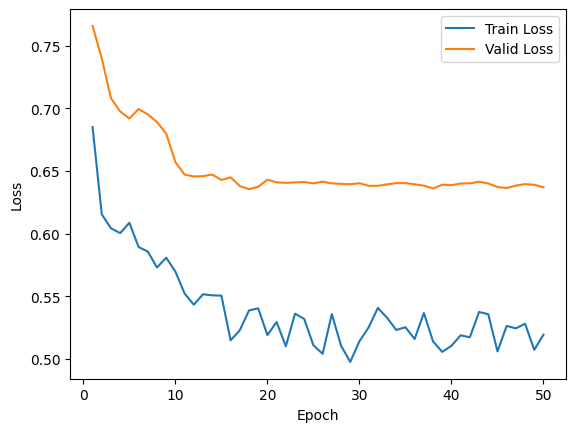

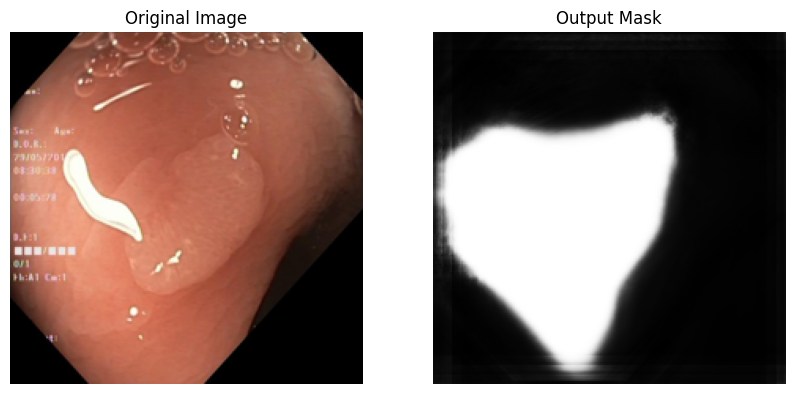

Test Loss: 0.5876


In [7]:

X, Y = load_data(img_size, img_size, img_num, dataset_type, folder_path)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)


print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)
# for i in range(x_train.shape[0]):
#     print(x_train[i].shape, y_train[i].shape)


# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)


# Creating the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUnetPlusPlus(channel=3)
# model.load_state_dict(torch.load(model_path))
model = model.to(device)


# Defining the optimizer, loss function and scheduler

loss = dice_metric_loss
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)


# Training the model


train_losses = []
valid_losses = []
x_valid = np.transpose(x_valid, (0, 3, 1, 2))
y_valid = np.transpose(y_valid, (0, 3, 1, 2))
x_valid = torch.from_numpy(x_valid).float().to(device)
y_valid = torch.from_numpy(y_valid).float().to(device)
print('Training begin...')
avg_valid_loss = 0.0

for epoch in range(num_epochs):
    model.train()
    x_train_aug, y_train_aug = augment_images()

    # reshaping the data
    x_train_aug = np.transpose(x_train_aug, (0, 3, 1, 2))
    y_train_aug = np.transpose(y_train_aug, (0, 3, 1, 2))


    x_train_aug = torch.from_numpy(x_train_aug).float().to(device)
    y_train_aug = torch.from_numpy(y_train_aug).float().to(device)

    train_dataset = TensorDataset(x_train_aug, y_train_aug)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    
    valid_dataset = TensorDataset(x_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

    # Initialize tqdm with the total number of batches
    t1 = tqdm(enumerate(train_loader), total=len(train_loader))



    # Initialize loss accumulator
    loss_accumulator = 0.0

    

    for i, (images, masks) in t1:
#     for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        masks_loss = masks[:, 0:1, :, :]
        optimizer.zero_grad()
        outputs = model(images)
        
#         print(outputs.shape, masks_loss.shape)
        loss_value = loss(outputs, masks_loss)
        loss_value.backward()
        optimizer.step()
        
        # Add the batch's loss to the accumulator
        loss_accumulator += loss_value.item()

        # Calculate the average loss over the epoch
        avg_train_loss = loss_accumulator / (i+1)

#         Update the progress bar
        t1.set_description(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}, Average Valid Loss: {avg_valid_loss:.4f}")


    model.eval()
    loss_accumulator = 0.0

    # t2 = tqdm(enumerate(valid_loader), total=len(valid_loader))

    with torch.no_grad():
        # for i, (images, masks) in t2:
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            masks_loss = masks[:, 0:1, :, :]
            valid_loss = loss(outputs, masks_loss)
            loss_accumulator += valid_loss.item()
        avg_valid_loss = loss_accumulator / len(valid_loader)
            # # Update the progress bar
            # t2.set_description(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}, Average Valid Loss: {avg_valid_loss:.4f}")

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    t1.set_description(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}, Average Valid Loss: {avg_valid_loss:.4f}")


    
    # print(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss.item():.4f}, 
    #       Average Valid Loss: {avg_valid_loss.item():.4f}")

    # Update the scheduler
    scheduler.step()

    # Saving the model
    if (epoch+1) % 10 == 0:
        save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch+1) + '.pth')
        torch.save(model.state_dict(), save_mode_path)
        
    # 训练后清理缓存
    torch.cuda.empty_cache()


# Plotting the loss curve
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()

# Saving the loss curve as an image
plt.savefig('loss_curve.png')

# Testing the model

model.eval()
with torch.no_grad():
    x_test = np.transpose(x_test, (0, 3, 1, 2))
    y_test = np.transpose(y_test, (0, 3, 1, 2))
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)
    outputs = model(x_test)
    masks_loss = y_test[:, 0:1, :, :]
    test_loss = loss(outputs, masks_loss)



    # Convert the output masks to numpy arrays
    output_masks = outputs.cpu().numpy()

    # Select one random output mask
    random_index = np.random.randint(len(output_masks))
    output_mask = output_masks[random_index]

    # Reshape the output mask to match the original image size
    output_mask = np.transpose(output_mask, (1, 2, 0))

    # Plot the original image and the corresponding output mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x_test[random_index].cpu().numpy().transpose(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(output_mask.squeeze(), cmap='gray')
    ax[1].set_title('Output Mask')
    ax[1].axis('off')

    # Show the plot
    plt.show()



print(f"Test Loss: {test_loss.item():.4f}")